TO DO
  
  2. need to clean up makefacedf2 function to remove 2 uses of same process
  3. do some visualizations
  4. get MAIN to take an input
  5. combine MAIN output with recommender input
 

In [3]:
%matplotlib inline
import requests
from PIL import Image, ImageDraw,ImageFont
import face_recognition
import pandas as pd
import numpy as np
from os.path import basename
import math
import pathlib
from pathlib import Path
import os
import random
import matplotlib.pyplot as plt

image_dir = "C:/Users/boyerm/_Capstone 3 Final/pics2"


In [4]:
%%html
<style>
.output_wrapper, .output {
    height:auto !important;
    max-height:1000px;  /* your desired max-height here */
}
.output_scroll {
    box-shadow:none !important;
    webkit-box-shadow:none !important;
}
</style>

In [ ]:
df = pd.DataFrame(columns = ['0','1','2','3','4','5','6','7','8','9','10','11',	'12',	'13',	'14',	'15',	'16','17',
                             '18',	'19',	'20',	'21',	'22',	'23',	'24','25',	'26',	'27',	'28',	'29',
                             '30',	'31',	'32',	'33',	'34',	'35',	'36',	'37',	'38',	'39',	'40',	'41',
                             '42',	'43',	'44',	'45',	'46',	'47',	'48',	'49',	'50',	'51',	'52',	'53',
                             '54',	'55',	'56',	'57',	'58',	'59',	'60',	'61',	'62',	'63',	'64',	'65',
                             '66',	'67',	'68',	'69',	'70',	'71',	'72',	'73',	'74',	'75',	'76',	'77',
                             '78',	'79',	'80',	'81',	'82',	'83',	'84',	'85',	'86',	'87',	'88',	'89',
                             '90',	'91',	'92',	'93',	'94',	'95',	'96',	'97',	'98',	'99',	'100',	'101',
                             '102',	'103',	'104',	'105',	'106',	'107',	'108',	'109',	'110',	'111',	'112',	'113',
                             '114',	'115',	'116',	'117',	'118',	'119',	'120',	'121',	'122',	'123',	'124',	'125',
                             '126',	'127',	'128',	'129',	'130',	'131',	'132',	'133',	'134',	'135',	'136',	'137',
                             '138',	'139',	'140',	'141',	'142',	'143','A1','A2','A3','A4','A5','A6','A7','A8','A9',
                            'A10','A11','A12','A13','A14','A15','A16','Width','Height','H_W_Ratio','Jaw_width','J_F_Ratio',
                             'MJ_width','MJ_J_width'])

The function in the py file (make_face_df2) is the key function. First, it finds all of the facial features, then it rotates the faces so they are facing forward by aligning around the eyes (I am working on another function now that aligns/rotates around the eyes not only as an angle, but also by placing the eyes in the exact same place on each image).  Then I calculate the angles between the chin point (9) and all of the lower facial features (1 - 17).  I also generate a few features: Face Width, Face Height, the ratio of height to face,	Jaw width, the ratio of the jaw to face width, the mid-jaw width and the mid-jaw to face width.

All of these points and features are then placed into a dataframe to start analyzing with various models.

The celebrity photos were first characterized into their face shapes, then a script is run to download 100 images from Google Images for each celebrity. The images were manually reviewed to ensure they will work for this project (image of celebrity's face, generally face-forward). The appropriate images are saved out to folders with the name of the classified shape. The function below accesses those folders and uses the folder names to classify the training and test images.

In [ ]:
%run -i functions_only.py    # This calls my main function 

In [ ]:
# #
# %run -i functions_only-save.py    # This calls my main function 
# # test file
# make_face_df2_save(("Ginnifer Goodwin (2).jpg"),1630    )


This function will run the main function on all of the photos in the above directory.

In [ ]:
# make df to store name of shape
      
data = pd.DataFrame()
data.reset_index
shape_df = pd.DataFrame(columns = ['filenum','filename','classified_shape'])
shape_array = []
def store_features_and_classification():
    filenum = -1
    sub_dir = [q for q in pathlib.Path(image_dir).iterdir() if q.is_dir()]
    start_j = 0
    end_j = len(sub_dir)

    for j in range(start_j, end_j):
        images_dir = [p for p in pathlib.Path(sub_dir[j]).iterdir() if p.is_file()]

        for p in pathlib.Path(sub_dir[j]).iterdir():
            print(p)

            shape_array= []
            if 1 == 1:
            #for f in pathlib.Path(q).iterdir():
            #   if q.is_file():
                    face_file_name = os.path.basename(p)
                    classified_face_shape = os.path.basename(os.path.dirname(p)) 
                    filenum += 1
                    make_face_df2(p,filenum)
                    shape_array.append(filenum)
                    shape_array.append(face_file_name)  
                    shape_array.append(classified_face_shape)
                    shape_df.loc[filenum] = np.array(shape_array)
            
            
store_features_and_classification()  
data = pd.concat([df, shape_df], axis=1)

In [ ]:
df

In [24]:
data.head()

,Unnamed: 0,0,1,2,3,4,5,6,7,8,...,Width,Height,H_W_Ratio,Jaw_width,J_F_Ratio,MJ_width,MJ_J_width,filenum,filename,classified_shape
0,0,90.0,104.0,91.0,121.0,94.0,138.0,98.0,155.0,103.0,...,137.295302,190.262976,1.385794,59.033889,0.429977,106.000000,1.795579,0,Amanda S 2.jpg,heart
1,1,80.0,97.0,82.0,115.0,85.0,133.0,88.0,152.0,96.0,...,144.055545,194.092761,1.347347,61.073726,0.423960,111.004504,1.817549,1,amanda seyfried 10.jpg,heart
2,2,85.0,104.0,86.0,121.0,89.0,138.0,92.0,156.0,99.0,...,136.235091,190.010526,1.394725,62.072538,0.455628,108.074049,1.741093,2,amanda seyfried 11.jpg,heart
3,3,74.0,108.0,76.0,127.0,80.0,145.0,85.0,164.0,93.0,...,143.055933,206.038831,1.440268,62.032250,0.433622,111.112556,1.791206,3,amanda seyfried 13.jpg,heart
4,4,85.0,97.0,85.0,113.0,87.0,129.0,92.0,145.0,99.0,...,134.003731,174.011494,1.298557,56.320511,0.420291,101.123687,1.795504,4,amanda seyfried 14.jpg,heart


In [ ]:
# Add all faces with shape to a DATA file for model
data.to_csv('all_features4.csv')


In [5]:
# load data file

data = pd.read_csv('all_features4.csv')

In [7]:
data.head()

,Unnamed: 0,0,1,2,3,4,5,6,7,8,...,Width,Height,H_W_Ratio,Jaw_width,J_F_Ratio,MJ_width,MJ_J_width,filenum,filename,classified_shape
0,0,90.0,104.0,91.0,121.0,94.0,138.0,98.0,155.0,103.0,...,137.295302,190.262976,1.385794,59.033889,0.429977,106.000000,1.795579,0,Amanda S 2.jpg,heart
1,1,80.0,97.0,82.0,115.0,85.0,133.0,88.0,152.0,96.0,...,144.055545,194.092761,1.347347,61.073726,0.423960,111.004504,1.817549,1,amanda seyfried 10.jpg,heart
2,2,85.0,104.0,86.0,121.0,89.0,138.0,92.0,156.0,99.0,...,136.235091,190.010526,1.394725,62.072538,0.455628,108.074049,1.741093,2,amanda seyfried 11.jpg,heart
3,3,74.0,108.0,76.0,127.0,80.0,145.0,85.0,164.0,93.0,...,143.055933,206.038831,1.440268,62.032250,0.433622,111.112556,1.791206,3,amanda seyfried 13.jpg,heart
4,4,85.0,97.0,85.0,113.0,87.0,129.0,92.0,145.0,99.0,...,134.003731,174.011494,1.298557,56.320511,0.420291,101.123687,1.795504,4,amanda seyfried 14.jpg,heart


# Visualizations

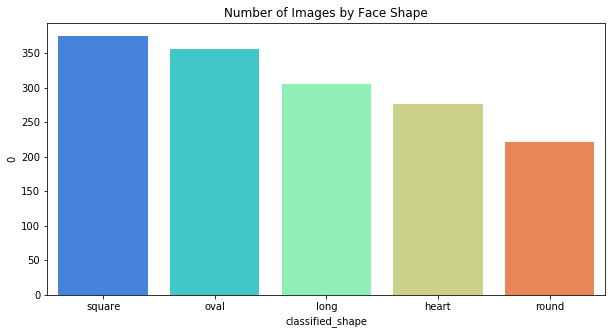

In [6]:
import seaborn as sns

# Summary statistics:

shape_count = data.groupby('classified_shape').count()['0'].sort_values(ascending=False).head(6)
g = sns.barplot(shape_count.index, shape_count, palette='rainbow')
g.figure.set_size_inches(10,5)
g.set_title("Number of Images by Face Shape")
plt.show()

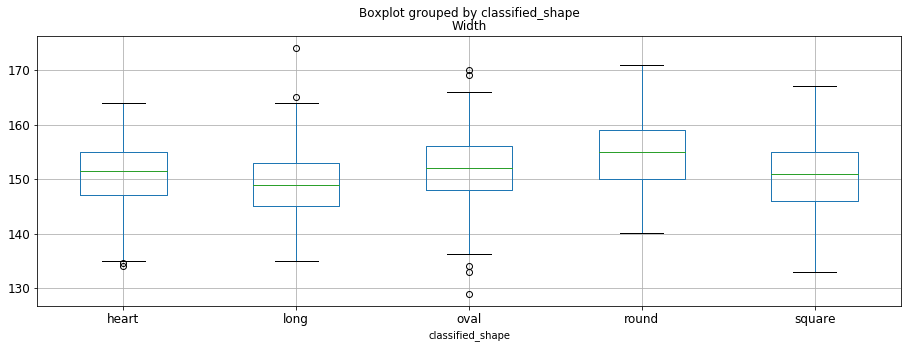

In [25]:
data.boxplot(column='Width', by='classified_shape', ax=None, fontsize=12, rot=0, grid=True, figsize=(15,5), 
                  layout=None, return_type=None)
plt.show()


In [60]:
data = data.dropna()

# Supervised Training

## Set up Test/Train for supervised training

In [ ]:
from sklearn import metrics
from sklearn.metrics import pairwise_distances
from sklearn.preprocessing import normalize
from sklearn.model_selection import train_test_split
from sklearn.cluster import KMeans
from sklearn import ensemble
from sklearn import linear_model
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import StandardScaler  

In [ ]:
data.shape

In [ ]:
data_clean = data.dropna(axis=0, how='any')
#data_clean = data

data_clean.shape

In [ ]:
#X = data_clean.iloc[:,145:171]
X = data_clean
X = X.drop(['filenum','filename','classified_shape'] , axis = 1)
X_norm = normalize(X)
Y = data_clean['classified_shape']

In [ ]:
# Split the data 
 
X_train, X_test, Y_train, Y_test = train_test_split(
    X,Y,
    test_size=0.25,
    random_state=None)

scaler = StandardScaler()  

scaler.fit(X_train)  
X_train_scaler = scaler.transform(X_train)  
X_test_scaler = scaler.transform(X_test) 

### Add PCA

In [ ]:
from sklearn.decomposition import PCA

n_components = 20
pca = PCA(n_components=n_components, svd_solver='randomized',
          whiten=True).fit(X_train_scaler)

X_train_pca = pca.transform(X_train_scaler)
X_test_pca = pca.transform(X_test_scaler)


In [ ]:
# turn off PCA
X_train_pca = X_train_scaler
X_test_pca = X_test_scaler

## Neural Network (MLP)

In [ ]:
mlp = MLPClassifier(hidden_layer_sizes=(60,10,60))
mlp.fit(X_train_pca, Y_train)
mlp.score(X_train_pca, Y_train)

print(mlp.score(X_train_pca,Y_train))

print(mlp.score(X_test_pca,Y_test))
y_pred = mlp.predict(X_test_pca)

pd.crosstab(Y_test, y_pred) 

In [ ]:
X_test.to_csv('xtest.csv')
Y_test.to_csv('ytest.csv')


In [ ]:
y_pred_df = pd.DataFrame(y_pred)

In [ ]:
y_pred_df.to_csv('ypred.csv')

In [ ]:
# Need to run the code on each person here.

In [ ]:
my_photo = 'marnie.jpg'
n = 2035
make_face_df2(my_photo,n)

In [ ]:
dfc = df
test_row = dfc.ix[n].values.reshape(1,-1)
test_row = scaler.transform(test_row)  
test_shape = mlp.predict(test_row)
print(test_shape)

# Recommender

In [1]:
%matplotlib inline
import requests
from PIL import Image, ImageDraw,ImageFont
import face_recognition
import pandas as pd
import numpy as np
from os.path import basename
import math
import pathlib
from pathlib import Path
import os
import random
import matplotlib.pyplot as plt

image_dir = "C:/Users/boyerm/_Capstone 3 Final/pics2"


In [10]:
%%html
<style>
.output_wrapper, .output {
    height:auto !important;
    max-height:1000px;  /* your desired max-height here */
}
.output_scroll {
    box-shadow:none !important;
    webkit-box-shadow:none !important;
}
</style>

In [2]:
image_dir = "C:/Users/boyerm/_Capstone 3 Final/rec_pics/heart"    #change to just rec_pics when all done
filenum = 0
sub_dir = [q for q in pathlib.Path(image_dir).iterdir() if q.is_dir()]
start_j = 0
end_j = len(sub_dir)
style_df = pd.DataFrame(columns = ['face_shape','hair_length','location','filename','score'])
for j in range(start_j, end_j):
            images_dir = [p for p in pathlib.Path(sub_dir[j]).iterdir() if p.is_file()]

            for p in pathlib.Path(sub_dir[j]).iterdir():
                shape_array= []

                face_file_name = os.path.basename(p)
                hair_length = os.path.basename(os.path.dirname(p)) 
                sub_dir_file = pathlib.Path(image_dir)
                face_shape = os.path.basename(os.path.dirname(os.path.dirname(p)) )

                shape_array.append(face_shape)
                shape_array.append(hair_length)
                shape_array.append(sub_dir_file)
                shape_array.append(face_file_name)  

                rand = random.randint(25,75)  # make a random score to start
                shape_array.append(rand)

                style_df.loc[filenum] = np.array(shape_array)

                filenum += 1

In [8]:
def run_recommender():
    name = input("What is your name? ")
    print("Hello, %s." % name)
    test_shape = ['heart']
    face_shape_input = test_shape[0] #input("What is your face shape?")
    if face_shape_input not in ['heart','long','oval','round','square']:
        face_shape_input = input("What is your face shape?")

    hair_length_input = input("Is your hair short (shoulder-length shorter) or long?")
    if hair_length_input in ['short','Short','s','S']:
            hair_length_input = 'Short'
    if hair_length_input in ['long','longer','l','L']:
            hair_length_input = 'Long'
    
    print(hair_length_input)
    r = 6
    
    n_col = 3
    n_row = 2
    recommended_df = style_df.loc[(style_df['face_shape'] ==face_shape_input) & (style_df['hair_length']== hair_length_input)].sort_values('score', ascending = 0).reset_index(drop=True)
    recommended_df = recommended_df.head(r)
    
    plt.figure(figsize=(5 * n_col, 4 * n_row))
    plt.subplots_adjust(bottom=0, left=.01, right=.99, top=.90, hspace=.35)
    font = ImageFont.truetype("arial.ttf", 60)
    for p in range(0,r):
        idea = str(recommended_df.iloc[p]['location'] ) + str('\\')+ str(recommended_df.iloc[p]['hair_length'] ) + str('\\') + str(recommended_df.iloc[p]['filename'] )
        idea = idea.replace('\\', '/')
        img = Image.open(idea)
        plt.subplot(n_row, n_col, p+1 )
        draw = ImageDraw.Draw(img)
        draw.text((10,10) ,str(p), fill=None, font=font, anchor=None)
        plt.imshow(img)
        img.close()

    plt.show()
    
    fav = input("Which style is your favorite?")
    yuck = input("Which file is your least favorite")
    # update scores based on fav/least fav

    for row in range(0,r):
        fn = recommended_df.at[row,'filename']
        srow = style_df.index[style_df['filename'] == fn].tolist()
        srow = srow[0]
        #print('Srow %s' %srow)
        if str(row) == str(fav):
            style_df.at[srow,'score'] =  style_df.at[srow,'score'] + 5
        if str(row) == str(yuck):
            style_df.at[srow,'score'] =  style_df.at[srow,'score'] - 5

What is your name? m
Hello, m.
Is your hair short (shoulder-length shorter) or long?l
Long


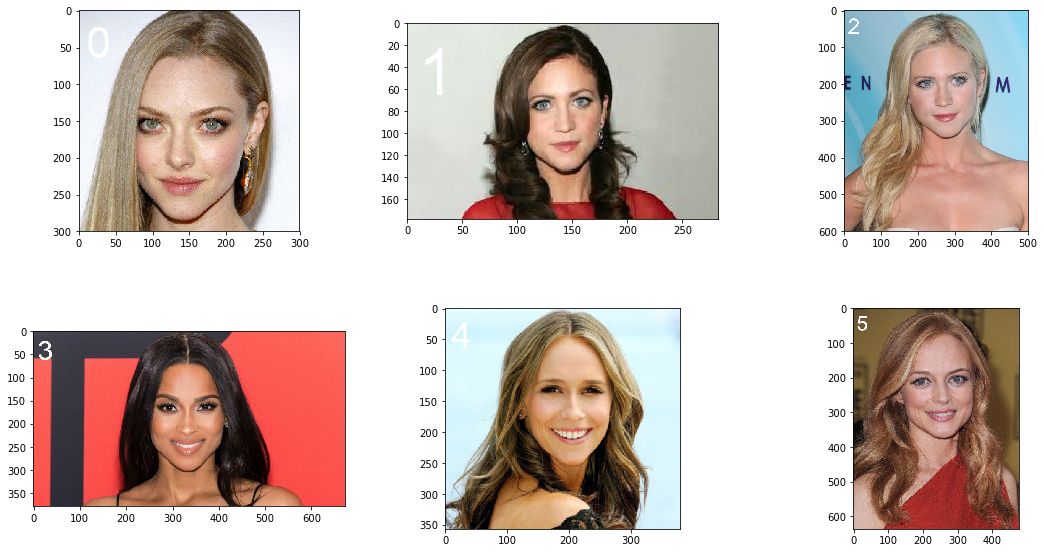

Which style is your favorite?1
Which file is your least favorite5


In [11]:
run_recommender()


What is your name? m
Hello, m.
Is your hair short (shoulder-length shorter) or long?l
Long


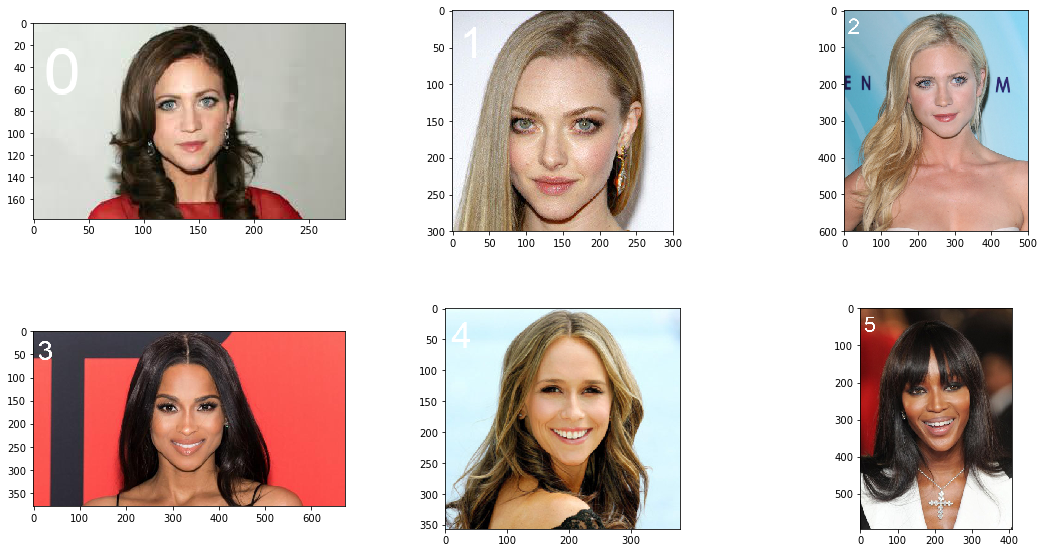

In [ ]:

run_recommender()